In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

training_size = 300000
batch_size = 128
epochs = 15
IMG_HEIGHT = 60
IMG_WIDTH = 28

CLASS_NAMES = np.array([])
for i in range(10):
    CLASS_NAMES =np.append(CLASS_NAMES,chr(ord("0")+i))
for i in range(26):
    CLASS_NAMES = np.append(CLASS_NAMES,chr(ord("A")+i))

#training dir / validation dir
train_dir_data01 = os.path.abspath(os.getcwd())+"\\train\\data01_train\\"
val_dir_data01 = os.path.abspath(os.getcwd())+"\\dev\\data01_dev"
num_train_data01 = len(os.listdir(train_dir_data01))
num_val_data01 = len(os.listdir(val_dir_data01))
print("Train data count: " + str(num_train_data01))
print("Validation data count: " + str(num_val_data01))

#store filename and label to a Dataframe 
import pandas as pd
data = pd.read_csv("train\\data01_train.csv")
for i in range(len(data)):
    data.iloc[i,1] = list(data.iloc[i,1])

#maybe there's an easier way to separate labels??
arr = np.zeros([6,50000],str)
for j in range(6):
    for i in range(len(data)):
        arr[j][i] = data.iloc[i,1][j]
data = data.drop(columns= ["code"]).join(pd.DataFrame(arr.transpose(),columns = ["code0","code1",'code2','code3','code4','code5']))

data

Train data count: 50000
Validation data count: 10000


,filename,code0,code1,code2,code3,code4,code5
0,000000.jpg,Z,3,2,7,0,D
1,000001.jpg,V,M,Y,X,E,8
2,000002.jpg,J,Z,K,W,V,U
3,000003.jpg,X,9,I,2,7,H
4,000004.jpg,H,5,X,G,R,2
...,...,...,...,...,...,...,...
49995,049995.jpg,3,Y,F,I,S,E
49996,049996.jpg,4,S,U,T,F,7
49997,049997.jpg,C,Y,U,N,0,9
49998,049998.jpg,K,C,D,8,I,O


In [2]:
def parse_label(strIN):
    return tf.expand_dims(strIN==CLASS_NAMES,0)

def cropimage_operation(fn,imxstart):
    a = tf.io.read_file((fn))
        #crop to [60,30,3]
    img = tf.image.decode_and_crop_jpeg(a,[0,imxstart,IMG_HEIGHT,IMG_WIDTH],channels=3)
    return tf.expand_dims(img,0)

In [3]:
#crop all words in the images and label all

for i in range(6):
    label = tf.data.Dataset.from_tensor_slices(data.iloc[:,i+1])
    TL= label.map(parse_label)
    train_dir = tf.data.Dataset.list_files(train_dir_data01+'*.jpg',shuffle=False) 
    TD = train_dir.map(lambda x: cropimage_operation(x,i*IMG_WIDTH))
    train_data = tf.data.Dataset.zip((TD,TL))   
    if i!=0:
        train_data01 = train_data01.concatenate(train_data)    
    else:
        train_data01 = train_data

In [5]:
def prep_data(dataset):
    dataprep = dataset.shuffle(num_elements,reshuffle_each_iteration=True)
    return dataprep
    
def show_batch(image_batchh, label_batchh):
  plt.figure(figsize=(14,10))
  for n in range(len(image_batchh)):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batchh[n][0])
      plt.title(CLASS_NAMES[np.where(label_batchh[n][0])])
      plt.axis('image')

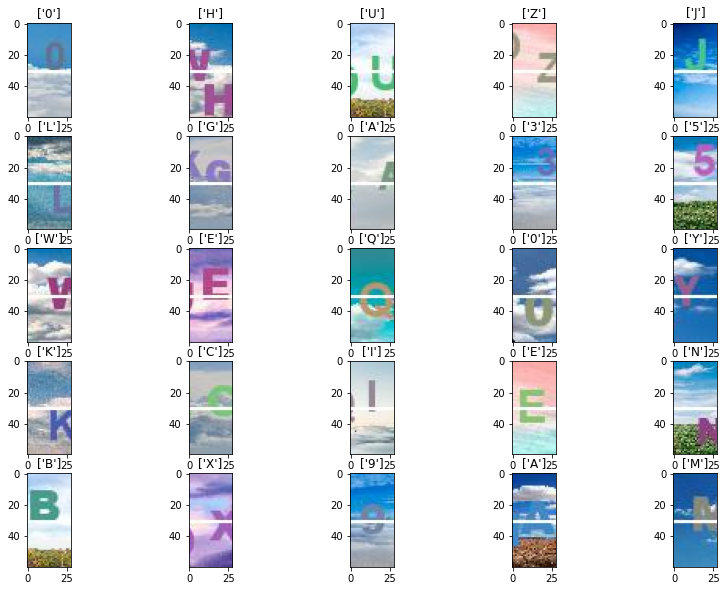

In [6]:
#only show batch when data is small
datapreped = prep_data(train_data01)
image_batch, label_batch = next(iter(datapreped.batch(25)))
show_batch(image_batch,label_batch)

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)), 
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.3),
    Dense(36,activation="softmax")
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#model.optimizer.lr=0.0001
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 26, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 26, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 58, 26, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 11, 64)        3

In [4]:
#number of element
num_elements = tf.data.experimental.cardinality(train_data01).numpy()
num_elements

300000

In [8]:
epochs=15
batch_size=128

In [12]:
history = model.fit(
       train_data01,
       batch_size=batch_size,
       shuffle=True,
       use_multiprocessing=True,
       steps_per_epoch=num_elements // batch_size, 
       epochs=epochs,
       verbose=1
    )

Epoch 1/15
2343/2343 - 10s - loss: 2.0522 - accuracy: 0.3799
Epoch 2/15
2343/2343 - 11s - loss: 1.9900 - accuracy: 0.4050
Epoch 3/15
2343/2343 - 11s - loss: 1.8483 - accuracy: 0.4456
Epoch 4/15
2343/2343 - 11s - loss: 1.8614 - accuracy: 0.4430
Epoch 5/15
2343/2343 - 10s - loss: 1.7430 - accuracy: 0.4904
Epoch 6/15
2343/2343 - 11s - loss: 1.6910 - accuracy: 0.4870
Epoch 7/15
2343/2343 - 11s - loss: 1.6284 - accuracy: 0.5083
Epoch 8/15
2343/2343 - 10s - loss: 1.5576 - accuracy: 0.5309
Epoch 9/15
2343/2343 - 11s - loss: 1.5914 - accuracy: 0.5087
Epoch 10/15
2343/2343 - 10s - loss: 1.4519 - accuracy: 0.5702
Epoch 11/15
2343/2343 - 10s - loss: 1.4361 - accuracy: 0.5459
Epoch 12/15
2343/2343 - 11s - loss: 1.5028 - accuracy: 0.5403
Epoch 13/15
2343/2343 - 10s - loss: 1.4162 - accuracy: 0.5792
Epoch 14/15
2343/2343 - 11s - loss: 1.3760 - accuracy: 0.5864
Epoch 15/15
2343/2343 - 10s - loss: 1.3823 - accuracy: 0.5830


In [137]:
#predict validation data
def predict_val(valdir):
    for i in range(6):
        valdata = valdir.map(lambda x: cropimage_operation(x,i*IMG_WIDTH))

        result = model.predict(
        valdata,
        use_multiprocessing = True
        )
    
        cd = np.array([],dtype = 'U32')
        for j in range(len(result)):
           cd = np.concatenate((cd,(CLASS_NAMES[np.where(result[j]==result[j].max())[0]]) ))

        if i==0:
           code = cd
        else:
          code = np.vstack((code,cd))
    a = code.transpose().tolist()
    return [''.join(row) for row in a]

val_dir = tf.data.Dataset.list_files(val_dir_data01+'*.jpg',shuffle=False) 
test = predict_val(val_dir)
val_file_name = pd.read_csv("./dev/data01_dev.csv")
val_file_name.join(pd.DataFrame(test,columns=["code"])).to_csv("data01_dev.csv",index = False)